# Predicting Movies Rating

## Introduction

The object of this Captstone Project was to predict movie rating using about 45,000 observations across 90 features. Although the label - movie rating - was originally a categorical variable consisting of entries between 0.5 and 5 incrementing by 0.5, it initially had 26 million rows across some 270,000 different critics, each of who reviewed on average around 580 movies. Once I group by movie id using the mean of the ratings, the label became a quasi-continuous variable of 44,800 movies and was used as such until rating was finally rounded off to the nearest half-integer at the very end of all the modeling. The data can be found across several CSV files at this link:  (https://www.kaggle.com/rounakbanik/the-movies-dataset). 

In all honesty, I was not able to achieve any outstanding results through the many models I employed. My conclusion is simply that the features I have in the cleaned data are not adept at predicting rating. Movie ratings are very subjective, especially for new or first time critics, but even for critics with many ratings, and simple facts of the movie - runtime, budget, production country, etc. - are generally not correlated with how high a critic will rank a movie. At least not strongly correlated. 

## Data Cleaning 

The first, and longest, step of this project was to clean the data. Normally, this mainly means deciding how to handle NaN values, but for this project in included several other steps, including: merging the dataframes, string replacement and deletion, feature type coercion, dropping redundant columns, creating dummy variables, and THEN imputing missing values. 

Since the process was so long, and because Imputation is a growing facet of data science that I believe should be considered separate from data cleaning, I will first walk through the cleaning process and then the Imputation process in a separate section


In [ ]:
#Import necessary packages
import pandas as pd
import os 
import numpy as np
from collections import Counter
import json
import ast

In [63]:
links = pd.read_csv("links.csv")
credits = pd.read_csv("credits.csv")
keywords = pd.read_csv("keywords.csv")
movies_meta = pd.read_csv("movies_metadata.csv")
ratings = pd.read_csv("ratings.csv")

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [7]:
movies_meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [8]:
#first, let's condense the ratings dataframe down by grouping it on critic ID
ratings = ratings.groupby(['movieId']).mean()
#first merge:
ratings_links = pd.merge(ratings, links, on = ['movieId'])

Before we merge any more dataframes, we mustclean up the imdb_id column in movies_meta because it has some character values attached to the Id values

In [9]:
movies_meta['imdb_id'] = movies_meta['imdb_id'].astype(str).str.replace('\D+', '')
movies_meta = movies_meta.drop(['homepage', 'overview', 'poster_path', 'tagline'], axis=1)
print(movies_meta.loc[:,['imdb_id']])

       imdb_id
0      0114709
1      0113497
2      0113228
3      0114885
4      0113041
...        ...
45461  6209470
45462  2028550
45463  0303758
45464  0008536
45465  6980792

[45466 rows x 1 columns]


At this point, the column imdb_id in movies_meta is an object instead of a float because there are some incorrect rows in it. Therefore I need to remove the problem rows, which are displayed when I try to run: *movies_meta['id'].astype('float64')*

In [10]:
#the first incorrect ID is the date '1997-08-20'
movies_meta[movies_meta['id' ] == '1997-08-20']
#so let's check whats going on on that row
movies_meta.iloc[19730,:]
#it's a pretty wacked up row, not much salvaging to be done, so let's drop it
movies_meta = movies_meta.drop(19730, axis = 0)

#now rerun trying to coerce the column to float64
    #it didn't work a second time, so we must remove another problem row
movies_meta[movies_meta['id' ] == '2012-09-29']
movies_meta = movies_meta.drop(29503, axis = 0)

movies_meta[movies_meta['id' ] == '2014-01-01']
movies_meta = movies_meta.drop(35587, axis = 0)

#now i can finally coerce the column to float64 once and for all
movies_meta['id'].astype('float64')
#let's coerce the column back to being being an Int
movies_meta['id'] = movies_meta['id'].astype(int)

In [11]:
#finally, let's merge again
ratings_links_meta = pd.merge(ratings_links, movies_meta, left_on = ["tmdbId"], right_on = ['id'])
ratings_links_meta.head()

,movieId,userId,rating,timestamp,imdbId,tmdbId,adult,belongs_to_collection,budget,genres,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,1,135121.043616,3.888157,1.113440e+09,114709,862.0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,2,134877.953761,3.236953,1.088621e+09,113497,8844.0,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,3,136520.452733,3.175550,9.661124e+08,113228,15602.0,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0
3,4,136249.536062,2.875713,9.390243e+08,114885,31357.0,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0
4,5,135293.275855,3.079565,9.896788e+08,113041,11862.0,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0


In [12]:
#shorten the release_year column
ratings_links_meta['release_year'] = pd.DatetimeIndex(ratings_links_meta['release_date']).year
ratings_links_meta['release_year'] = ratings_links_meta['release_year'].astype(pd.Int32Dtype())

#add a months column from release_year
ratings_links_meta['release_month'] = pd.DatetimeIndex(ratings_links_meta['release_date']).month
ratings_links_meta['release_month'] = ratings_links_meta['release_month'].astype(pd.Int32Dtype())

In [13]:
#finally, let's drop the release_date column because it's no longer necessary
ratings_links_meta.drop('release_date', axis =1, inplace = True)

#drop columns that are useless for either modeling or interpreation or both
ratings_links_meta.drop(['userId', 'timestamp'], axis = 1, inplace = True)

#make "belongs_to_collection" a binary variable instead of a most empty list of dictionaries
ratings_links_meta['collection'] = np.where(ratings_links_meta['belongs_to_collection'].isna(),0,1)
ratings_links_meta.drop('belongs_to_collection', axis = 1, inplace = True)

In [14]:
#Let's find out which rows are causing the Na values
ratings_links_meta[ratings_links_meta['popularity'].isna()]

#and let's drop those rows!
ratings_links_meta.drop([19777, 29224, 35206], axis = 0, inplace = True)

Now its time to extract data from the columns with lists of dictionaries, such as genres and spoken_languages, For each column in this form, I created a function to be applied to said column, which would grab the list of dictionaries as a string, coerce it either to json via json.loads, or evaluate the string literally using ast.literal eval. The reason for using both is because some of the strings were more complex than others, such that of production_countries, and thus included character values that json.loads() would not accept. For example, the apostrophe in Côte d'Ivoire is interpreted by json.loads() as the marker of the end of a character, and thus threw an error. 

In [15]:
#undo the genres dictionary
def getGenres(string):
    final_list = []
    string = string.replace("'", '"') 
    dict_string = json.loads(string)
    for i in dict_string:
        final_list.append(i["name"])
    return final_list

ratings_links_meta['genre_name'] = ratings_links_meta['genres'].apply(getGenres)

In [16]:
def getProductionCompanies(string):
    final_list = []
    dict_i = ast.literal_eval(string)
    for j in dict_i:
        final_list.append(j["name"]) 
    return final_list

ratings_links_meta['top_production_companies'] = ratings_links_meta['production_companies'].apply(getProductionCompanies) 
ratings_links_meta['top_production_companies'] = [[x.replace(" Corporation", '') for x in l] for l in ratings_links_meta['top_production_companies']]
ratings_links_meta['top_production_companies'].shape
c = Counter(x for xs in ratings_links_meta['top_production_companies'] for x in set(xs))
len(c) #there are 23383
c.most_common(13)

[('Warner Bros.', 1195),
 ('Metro-Goldwyn-Mayer (MGM)', 1015),
 ('Paramount Pictures', 991),
 ('Columbia Pictures', 858),
 ('Universal Pictures', 831),
 ('Twentieth Century Fox Film', 820),
 ('Canal+', 442),
 ('United Artists', 282),
 ('New Line Cinema', 277),
 ('RKO Radio Pictures', 273),
 ('Walt Disney Pictures', 263),
 ('Touchstone Pictures', 225),
 ('TriStar Pictures', 197)]

In [17]:
#UNDO PRODUCTION COUNTRIES
def getProductionCountries(string):
    final_list = []
    dict_i = ast.literal_eval(string)
    for j in dict_i:
        final_list.append(j["name"])
    return final_list
ratings_links_meta['production_locations'] = ratings_links_meta['production_countries'].apply(getProductionCountries)
ratings_links_meta['production_locations'].shape

mylist = []
for i in list(ratings_links_meta["production_countries"]):
    dict_i = ast.literal_eval(i)
    for j in dict_i:
        mylist.append(j["name"])
        
count = Counter(mylist) #there are 159 different production countries
top = count.most_common(30)
top_countries =  []  
for i in top:
    top_countries.append(i[0])

In [18]:
#UNDO SPOKEN LANGUAGES 
def getLanguages(string):
    final_list = []
    string = string.replace("'", '"') 
    string = string.replace("\\", "")
    dict_string = json.loads(string)
    for i in dict_string:
        final_list.append(i["name"])
    return final_list

ratings_links_meta['language'] = ratings_links_meta['spoken_languages'].apply(getLanguages)

mylist = []
for i in list(ratings_links_meta["spoken_languages"]):
    i = i.replace("'", '"')
    i = i.replace('\\', '')
    dict_i = json.loads(i)
    for j in dict_i:
        mylist.append(j["name"])  
        
count = Counter(mylist)
len(count) #there are 75 unique languages spoken
top_lang = count.most_common(20)
top_languages = []
for i in top_lang:
    top_languages.append(i[0])

Finally, it's time to create dummy variables out of the new columns. Unfortunatety, at this step I had to drop my favorite column, the production_companies feature. With Over 20,000 unique companies, it was too large for pandas to get dummy variables for it. Using Counter method, I found the top 13 companies and grouped all other companies as "Other." However, this unfortunately destroyed the structure of the dataframe so as to prohibit pd.get_dummies to function. 

Since a few days ago, I believe now I have figured out how to incorporate production companies, but since I do not have time to rerun all the feature selection algorithms, I will leave it out for now. 

In [19]:
genres_data = ratings_links_meta['genre_name'].str.join(sep = '*').str.get_dummies(sep='*')
genres_columns = genres_data.columns
#once I have the dummy variables I want, I concat them to my main dataframe
ratings_links_meta = pd.concat([ratings_links_meta, genres_data], axis =1)

#for production countries dataset
prod_countries = ratings_links_meta['production_locations'].str.join(sep = '*').str.get_dummies(sep='*')
prod_countries = prod_countries.filter(top_countries)
prod_countries.columns
ratings_links_meta = pd.concat([ratings_links_meta, prod_countries], axis =1)
#where top_countries was previouly defined as the top 30 countries where movies were filmed

#for spoken languages
lang_spok = ratings_links_meta['language'].str.join(sep = '*').str.get_dummies(sep='*')
lang_spok = lang_spok.filter(top_languages)
lang_spok.columns
ratings_links_meta = pd.concat([ratings_links_meta, lang_spok], axis =1)

In [20]:
#here are the last columns of dtype object that can be changed into floats or integers
ratings_links_meta['popularity'] = ratings_links_meta['popularity'].astype('float64')
ratings_links_meta['budget'] = ratings_links_meta['budget'].astype(int)
ratings_links_meta['adult'] = (ratings_links_meta['adult'] == 'True').astype(int)
ratings_links_meta['video'] = (ratings_links_meta['video'] == 'True').astype(int)

#finally, let's drop all the old dictionary columns
ratings_links_meta.drop(['movieId', 'genres', 'imdb_id', 'original_language', 'original_title', 
               'production_companies', 'production_countries', 'spoken_languages', 
               'genre_name', 'top_production_companies','production_locations', 'language', 'title', 'tmdbId'], 
              axis =1, inplace = True)

Once the data had been been aside from NaN values, I wrote a new CSV file to save my work. 

Since I have already written the csv in another file and place in the working directory of this documnet, I will comment out this next line of code

In [21]:
# ratings_links_meta.to_csv("movies_data.csv", index = False, header = True)
data = pd.read_csv("movies_data.csv")

## Imputation Using AutoImpute

AutoImpute in a Python imputation and missing data analysis package introduced for the first time at PyData 2019 in Los Angeles. While many complex imputation packages exist in R, such as the MICE or Amelia packages, AutoImpute is the first robust imputation module in python that implements machine learning to replace missing values. AutoImpute uses similar if not the same syntax as other sklearn modules, so there is effectively no learning curve. And, as more machine learning algorithms are being added currently, the package grows more robust. Currently, it supports about 22 algorithms for Univariate, Multivariate, and Times Series/Interpolation, and can perform either a Single Imputations (running through the data once) or Multple Imputations (running through the the data M times).

AutoImpute suggests handling missing data with a 4 step process. That process is as follows: 

 1.  Assess the extent of the missing value problem with discriptive and visual measures
 2.  Examine factors related to missingness
 3.  Try several imputation methods to determine which is best
 4.  Measure the impact of imputation to the fit, stability, bias, and variance 

In [47]:
#imports:
import seaborn as sns
import sklearn as skl
import math

#for auto impute
from autoimpute.imputations import SingleImputer
import autoimpute as autoimp
from autoimpute.visuals import plot_md_percent
from autoimpute.visuals import plot_md_locations
from seaborn import countplot

#for feature selection
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#for modeling
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.linear_model import SGDRegressor

### Step 1:  Assess Extent of Missingness

In [23]:
column_names = data.columns.tolist()
for i in range(len(data.columns)):
    b = column_names[i]
    c = data.iloc[:,i].isna().sum()
    print(f"{b} : {c}")
    

rating : 0
imdbId : 0
adult : 0
budget : 0
id : 0
popularity : 0
revenue : 0
runtime : 254
status : 79
video : 0
vote_average : 0
vote_count : 0
release_year : 82
release_month : 82
Action : 0
Adventure : 0
Animation : 0
Comedy : 0
Crime : 0
Documentary : 0
Drama : 0
Family : 0
Fantasy : 0
Foreign : 0
History : 0
Horror : 0
Music : 0
Mystery : 0
Romance : 0
Science Fiction : 0
TV Movie : 0
Thriller : 0
War : 0
Western : 0
United States of America : 0
United Kingdom : 0
France : 0
Germany : 0
Italy : 0
Canada : 0
Japan : 0
Spain : 0
Russia : 0
India : 0
Hong Kong : 0
Sweden : 0
Australia : 0
South Korea : 0
Belgium : 0
Finland : 0
Denmark : 0
Netherlands : 0
China : 0
Mexico : 0
Poland : 0
Brazil : 0
Argentina : 0
Switzerland : 0
Ireland : 0
Czech Republic : 0
Austria : 0
Norway : 0
Hungary : 0
Greece : 0
English : 0
Français : 0
Deutsch : 0
Español : 0
Italiano : 0
日本語 : 0
Pусский : 0
普通话 : 0
हिन्दी : 0
Português : 0
svenska : 0
한국어/조선말 : 0
Polski : 0
广州话 / 廣州話 : 0
suomi : 0
Magyar : 0

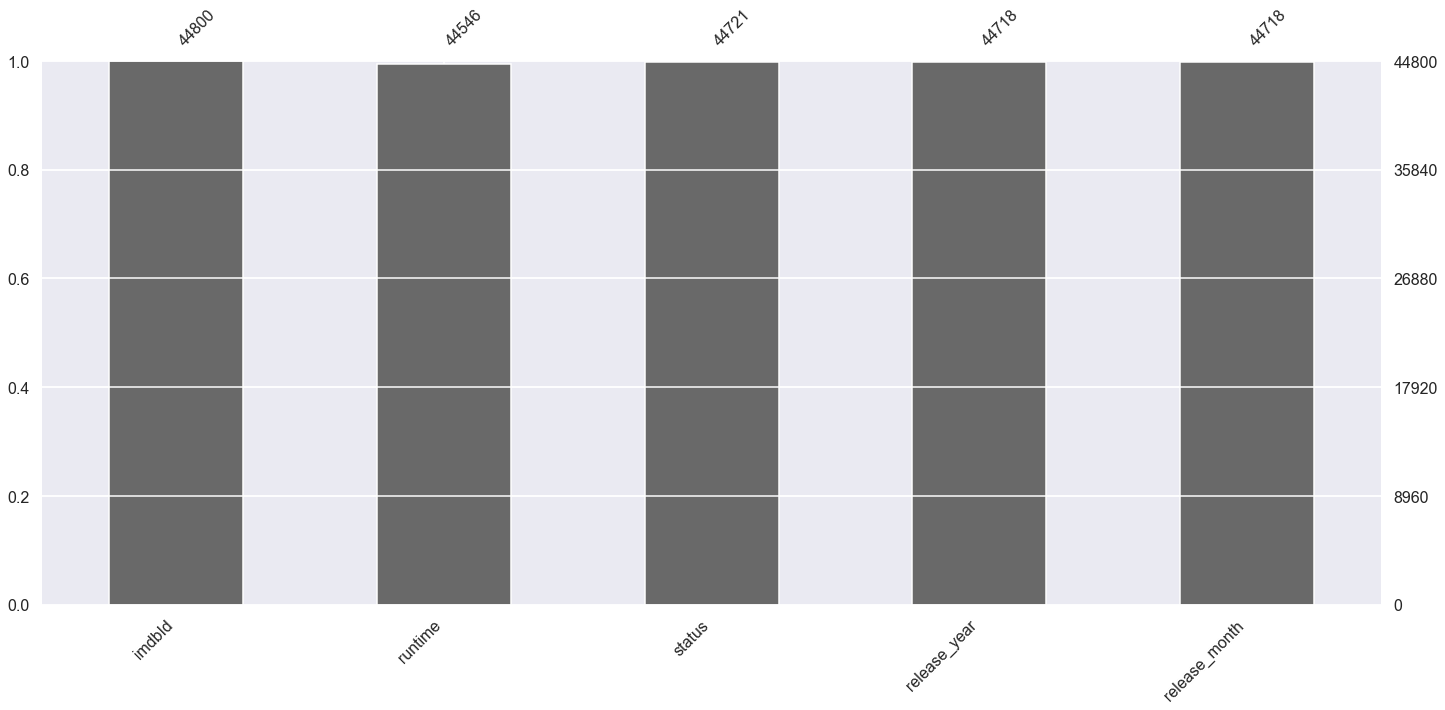

In [24]:
autoimp.visuals.plot_md_percent(data.iloc[:,[1,7,8,12,13]])

As we can see in the above graph and output, four columns in the data frame have missing data values - runtime, status, release_year, and release_month. However, compared to a column that has no missing values, such as imdbId, the percentage of missing values is barely noticeable graphically against a complete column. 

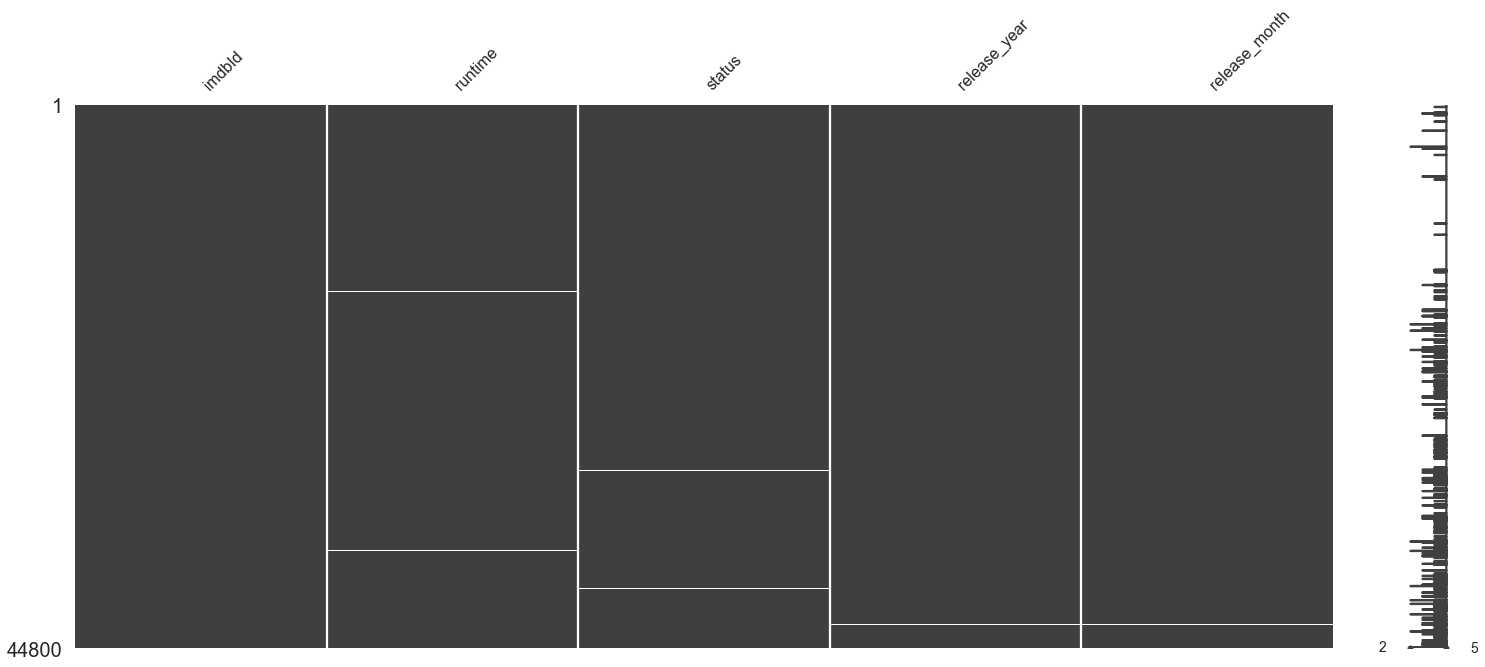

In [25]:
autoimp.visuals.plot_md_locations(data.iloc[:,[1,7,8,12,13]])

The graph above shows how random the missing data is. In this case, there is not enough missing data to really observe a pattern. However, it is worth noting that release_year and release_month both have NaN in the exact same rows, due to the fact that those two columns were parsed from one original column called release_date

[Text(0, 0.5, 'Proportion'), Text(0.5, 0, 'Release Year')]

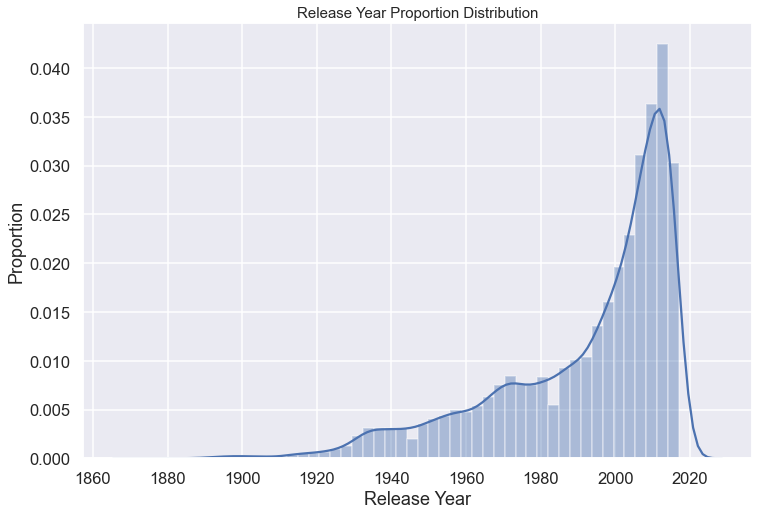

In [26]:
plot_year = sns.distplot(data['release_year'])
plot_year.set_title("Release Year Proportion Distribution", fontsize = 15)
plot_year.set(xlabel = "Release Year", ylabel = "Proportion")

As you can see, the release_year distribution is exremely left-skewed, meaning most movies included in the dataframe are modern movies of the last 20 years. The growth seems exponential, and only dips in 2018 because movies from only half the year are included in this dataset. Since exponential is not a distrubtion supported by AutoImpute, I will have to use an alternative. 

[Text(0, 0.5, 'Proportion'), Text(0.5, 0, 'Release Month')]

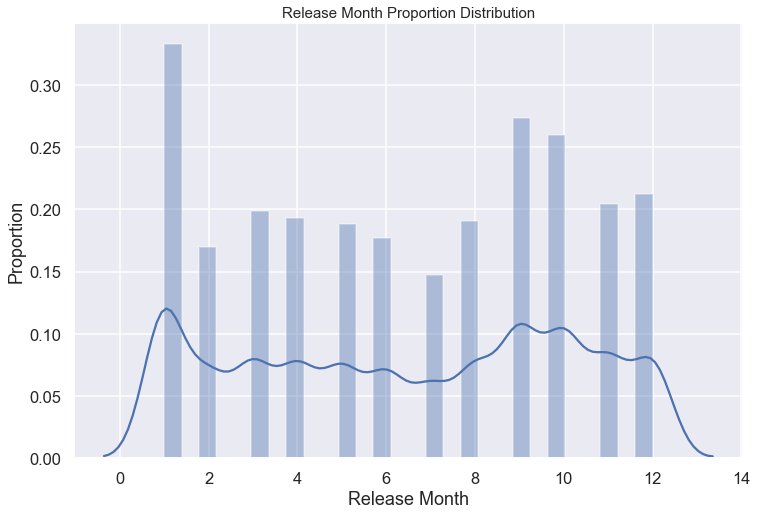

In [27]:
plot_month = sns.distplot(data['release_month'])
plot_month.set_title("Release Month Proportion Distribution", fontsize = 15)
plot_month.set(xlabel = "Release Month", ylabel = "Proportion")

Conversely, the distribution of Release Month seems largely uniform. The 'random' option of AutoImpute should suffice. 

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Movie Status')]

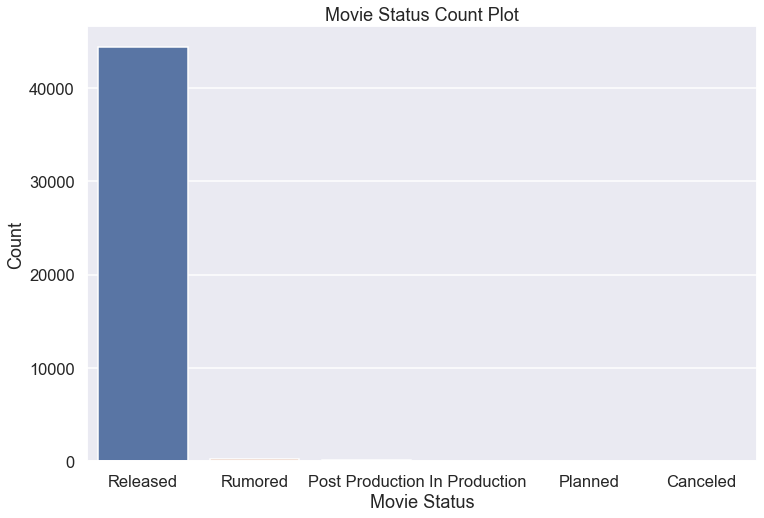

In [28]:
status_plot = countplot(data = data, x = 'status')
status_plot.set_title("Movie Status Count Plot")
status_plot.set(xlabel = 'Movie Status', ylabel = "Count")

For the categorical variable "Movie Status," the vast, vast majority of observations are Released, which makes since! Most movies with ratings are released! AutoImpute can handle categorical variables, but I think we all know what the default selection will be...  

[Text(0, 0.5, 'Proportion'), Text(0.5, 0, 'Runtime (in minutes)')]

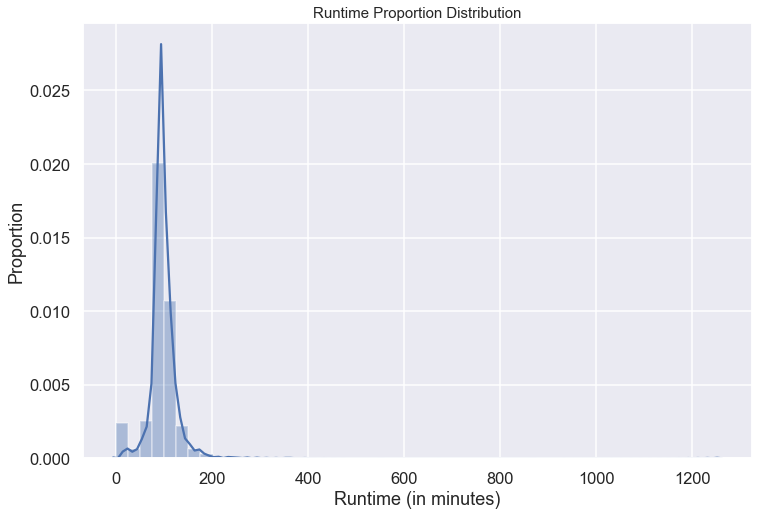

In [29]:
plot_runtime = sns.distplot(data['runtime'])
plot_runtime.set_title("Runtime Proportion Distribution", fontsize = 15)
plot_runtime.set(xlabel = "Runtime (in minutes)", ylabel = "Proportion")

In [30]:
sum(data['runtime'] > 400)

50

Finally, we can see that the distribution of runtime is roughly normal, with a slight bump in the 0-10 minute range for short films, as well as an extreme right skew for the extremely long movies. The above output shows that there are 50 movies with runtimes over 400, and one even with a runtime longer than 1200 minutes! As a bit of research, I discovered 'movie' titled Centennial is actually a TV mini-series. However, because the directors specifically wanted it to be considered the longest movie ever made, with a runtime of 1,256 minutes, I decided to keep it and other like it in the dataset. 

In [31]:
ratings_links_meta[ratings_links_meta['runtime'] > 1200]
ratings_links_meta.iloc[24156, 10:15]

vote_average      7.9
vote_count          8
release_year     1978
release_month      10
collection          0
Name: 24157, dtype: object

### Step 2: Examine reasons for missingness

This step requires more missing values and domain expertise to adequately assess. From what I can tell, the data is MAR - Missing at Random. It may even be MCAR - Missing Completely at Random - but that is an extremely strict classification to achieve. 

### Step 3: Attempt Imputation

In [32]:
single = SingleImputer(
    strategy = {'status' : "categorical", 'release_year': "median", 'runtime': 'norm', 'release_month': 'random'}
    )
data = single.fit_transform(data)

It should be noted that I attempted several more robust imputations, but kept getting gradient errors, specifically when working with the Predictive Mean Matching algorithm that is the default of AutoImpute. My guess is that the mismatch in value counts in the data - such as for the categorical variable 'status' - drove the gradient to zero (i.e. the local minimum was not the global minimum), but that may be wrong. A second guess is that I must further specificy PMM arguments for the Multiple Imputer to work, but that route proved to required too much research for this project. 

### Step 4: Measure Impact of Imputation

[Text(0, 0.5, 'Proportion'), Text(0.5, 0, 'Release Month')]

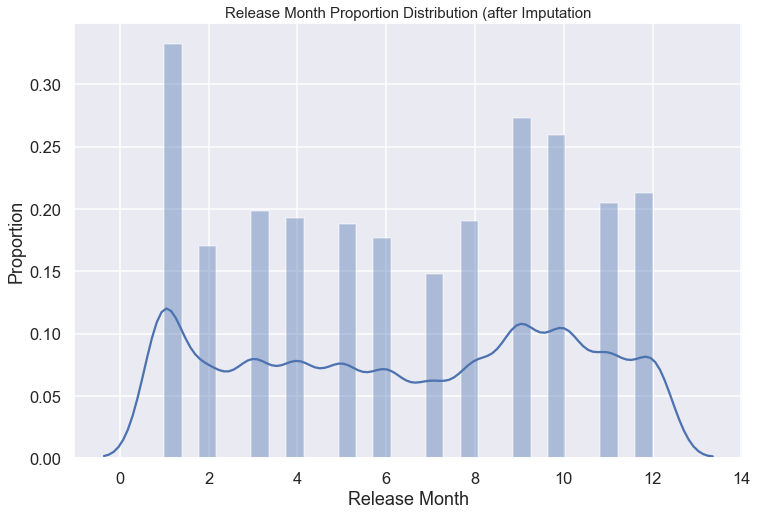

In [33]:
plot_month_clean = sns.distplot(data['release_month'])
plot_month_clean.set_title("Release Month Proportion Distribution (after Imputation", fontsize = 15)
plot_month_clean.set(xlabel = "Release Month", ylabel = "Proportion")

There is no discernable difference betweeen the clean data and messy data. 

## Further Visualizations

[Text(0, 0.5, 'Runtime'), Text(0.5, 0, 'Release Year')]

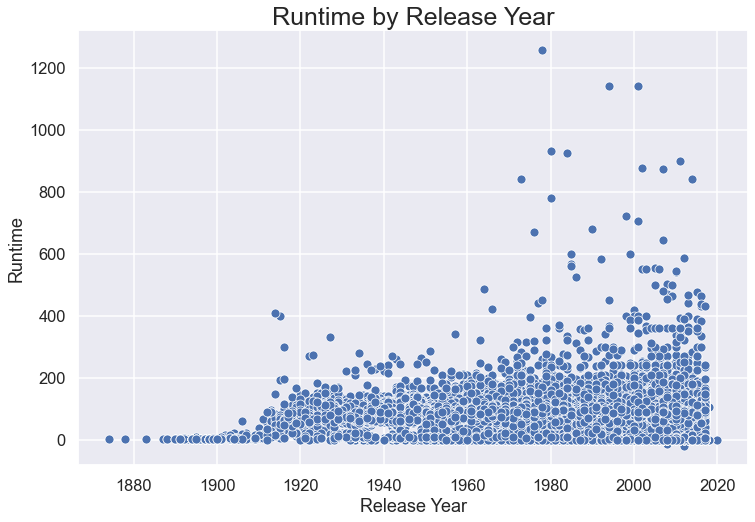

In [58]:
scatter = sns.scatterplot(x = 'release_year', y = 'runtime', data = data)
scatter.set_title("Runtime by Release Year", fontsize = 25)
scatter.set(xlabel = "Release Year", ylabel = "Runtime")

[Text(0, 0.5, 'Count (in millions)'), Text(0.5, 0, 'Movie Rating')]

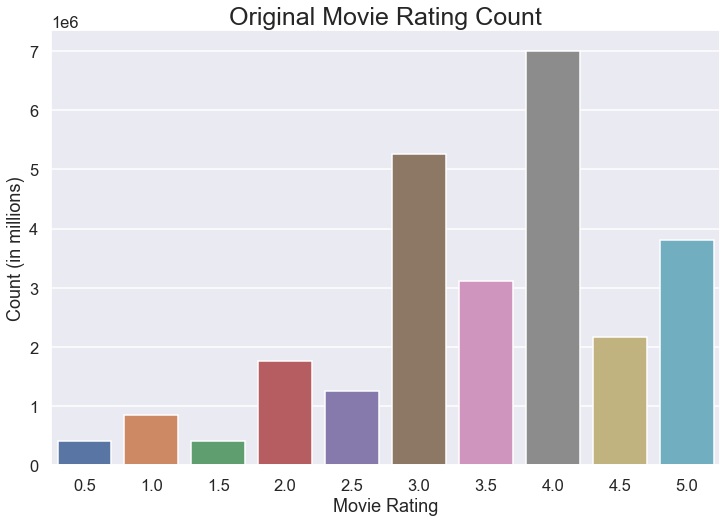

In [67]:
ratings_plot = countplot(data = ratings, x = 'rating')
ratings_plot.set_title("Original Movie Rating Count", fontsize = 25)
ratings_plot.set(xlabel = "Movie Rating", ylabel = "Count (in millions)")

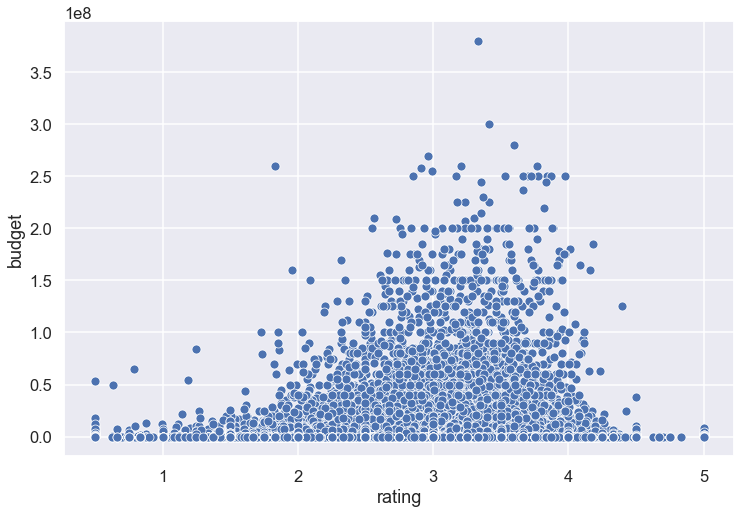

In [69]:
sns.scatterplot(x = 'rating', y = 'budget', data = data)

The outlier with the huge budget (350 million) is Pirates of the Carribean: On Stranger Tides

## Modeling 

Finally it is time to begin modeling!

In [34]:
#get the last dummy variables 
x = pd.get_dummies(data, columns= ['status'], drop_first = True)
y  = data['rating']

x.drop(['rating', 'imdbId', 'id'], axis = 1, inplace = True)

In [35]:
#split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [36]:
#find higly correlated variables
correlated_features = set()
correlation_matrix = x.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(correlated_features)        

{'vote_count', 'suomi', '日本語', '한국어/조선말'}


In [37]:
#x_train.drop(labels = correlated_features, axis = 1, inplace = True)  
#x_test.drop(labels = correlated_features, axis = 1, inplace = True)

In [38]:
#scale the variables

scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

### Linear Regression Models

To kick off the modeling, I decided to go with a basic linear regression model to establish a baseline MSE and R squared upon which all other models hopefully improve. 

In [39]:
model = LinearRegression()
model.fit(x_train, y_train)
r_sq = model.score(x_train, y_train)
print("Simple OLS R_squared")
print(f"R_squared : {r_sq}\n")

y_pred_lin = model.predict(x_test)
mse_ols = mean_squared_error(y_pred_lin, y_test)
print("Mean Squared Error for OLS Predictions")
print(f"MSE = {mse_ols}")

Simple OLS R_squared
R_squared : 0.208446264077908

Mean Squared Error for OLS Predictions
MSE = 0.4201524444846823


As we can see, the OLS R_squared is only 0.208, signifying that only 20% of the variance in movie rating is explained by the other columns. The MSE is 0.42, which signifies that on average, each predicted rating is about 0.64 of a rating off of the actual rating. Considering that the true ratings increment by 0.5, this MSE is not very good; most predictions are off by more than one full rating difference. 

### Polynomial Regression

In [41]:
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_train)
model_ply = LinearRegression().fit(x_, y_train)
poly_r2 = model_ply.score(x_, y_train)
print("Polynomial Regression R_squared")
print(f"R_squared : {r_sq}\n")

#y_test_ply = model_ply.predict(x_)
#mse_poly = mean_squared_error(y_test, y_test_ply)
#print("Mean Squared Error for OLS Predictions")
#print(f"MSE = {mse_poly}")

Polynomial Regression R_squared
R_squared : 0.208446264077908



NameError: name 'x_test1' is not defined

In [ ]:
sgd.score(np.array(x_test1),y_test)

### Random Forest Regressor

All the below code was run in spyder before being copy and pasted into this jupyter notebook file. Since some of these algorithms take 5+ hours each to run, I not rerun them here

In [ ]:
parameters = {
              "n_estimators" : [25,50,100, 150, 500],
              "max_depth" : [1,2,4,5,7,9,10,15],
              "min_samples_split" : [2,5],
              "min_samples_leaf" : [1,2,5]
    } 
clf = GridSearchCV(RandomForestRegressor(), parameters, cv = 3, scoring= 'explained_variance')
#clf.fit(x_train, y_train.values.ravel())
print(clf.best_params_)
print(clf.score(x_train, y_train.values.ravel()))

In [43]:
#let's try random forest regressor
Rand = RandomForestRegressor(max_depth = 10, min_samples_leaf=5, min_samples_split=5, n_estimators = 500, max_features=int(math.sqrt(len(g))))
rfecv2 = RFECV(estimator = Rand, cv = 3, step = 0.02)
#rfecv2 = rfecv2.fit(x_train, y_train.values.ravel())
#g = rfecv2.get_support(1)


In [42]:
g = [1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26,
 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 49, 59, 60, 61, 63, 64, 66, 67, 70]

In [50]:
#subset x_train1 by the good predictors
x_train1 = pd.DataFrame(x_train)
x_train1 = x_train1[x_train1.columns[g]]
x_test1 = pd.DataFrame(x_test)
x_test1 = x_test1[x_test1.columns[g]]
Rand.fit(x_train1, y_train.values.ravel())
y_train_predict = Rand.predict(x_train1)


In [51]:
mse_rf = mean_squared_error(y_train, y_train_predict)
r2_rf = r2_score(y_train, y_train_predict)

print("Random Forest R_squared")
print(f"R_squared : {r2_rf}\n")

print("Mean Squared Error for Random Forest Predictions")
print(f"MSE = {mse_rf}")

Random Forest R_squared
R_squared : 0.3147839498048399

Mean Squared Error for Random Forest Predictions
MSE = 0.3654276687489212


### SGD Regressor

In [52]:
sgd = SGDRegressor( penalty = 'elasticnet', shuffle = True, random_state = 42)
sgd.fit(x_train1, y_train)
y_test_sgd = sgd.predict(x_test1)
sgd_r2 = sgd.score(np.array(x_train1),y_train)
mse_sgd = mean_squared_error(y_test, y_test_sgd)

print("Ridge/Lasso R_squared")
print(f"R_squared : {sgd_r2}\n")

print("Mean Squared Error for Ridge/Lasso Predictions")
print(f"MSE = {mse_sgd}")

Ridge/Lasso R_squared
R_squared : 0.19688176883298736

Mean Squared Error for Ridge/Lasso Predictions
MSE = 0.4279149856887718


### XGBoost

In [53]:
#let's try xgboost

model_xgb = xgb.XGBRegressor(random_state = 42, learning_rate = 0.01)
model_xgb.fit(x_train, y_train)
y_test_xgb = model_xgb.predict(x_test)

In [56]:
print(model_xgb.score(x_train, y_train))
print(model_xgb.score(x_test, y_test))
mse_xgb = mean_squared_error(y_test, y_test_xgb)
print("Mean Squared Error for XGBoost")
print(f"MSE = {mse_xgb}")

-1.378318778338219
-1.4524243318614092
Mean Squared Error for XGBoost
MSE = 1.3039260746424326


### Model Results

# Results Discussion